# Time Optimal Velocity Profiles

When the maze solver commands that the robot go forward, it can say that it must go forward one or more squares depending on what it knows about the maze. When we don't know what is after the square we pass through, we must be going slow enough to handle any scenario. In other words, there is some $V_f$ that we must reach by the end of our motion. We also begin motions at this speed, since between we arrived where we are we required that we reach $V_f$ to get there. Therefore, we start and end at $V_f$, and we want to cover some distance $d$ in the fast possible time. To do so, we accelerate at our fixed $a$ until we reach max speed, or until we need to start slowing down (whichever comes first). This gives us a trapezoid shaped velocity profile.

## Going Straight

In [1]:
%load_ext tikzmagic

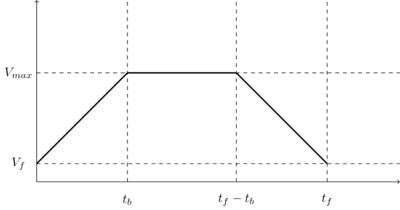

In [2]:
%%tikz -s 400,400
\draw[->] (0,0) -- (10,0);
\draw[->] (0,0) -- (0,5);

\draw[line width=1] (0,0.5) -- (2.5,3);
\draw[line width=1] (2.5,3) -- (5.5,3);
\draw[line width=1] (5.5,3) -- (8,0.5);
\draw[dashed] (0,0.5) -- (10,0.5);
\draw[dashed] (0,3) -- (10,3);
\draw[dashed] (2.5,0) -- (2.5,5);
\draw[dashed] (5.5,0) -- (5.5,5);
\draw[dashed] (8,0) -- (8,5);

\draw (-0.5, 0.5) node {$V_{f}$};
\draw (-0.5, 3) node {$V_{max}$};
\draw (2.5, -0.5) node {$t_b$};
\draw (5.5, -0.5) node {$t_f-t_b$};
\draw (8, -0.5) node {$t_f$};

The time to accelerate from $V_f$ to $V_{max}$ is $t_b = \frac{V-V_f}{a}$. We can substitute this into newtons first equation of motion as follows.

\begin{align}
d &= Vt_b - \frac{1}{2}a{t_b}^2 \\
  &= V\Big(\frac{V-V_f}{a}\Big) - \frac{1}{2}a\Big(\frac{V-V_f}{a}\Big)^2 \\
  &= \Big(\frac{V^2-VV_f}{a}\Big) - \Big(\frac{a(V-V_f)^2}{2a^2}\Big) \\
  &= \Big(\frac{2V^2-2VV_f}{2a}\Big) - \Big(\frac{V^2-2VV_f+{V_f}^2}{2a}\Big) \\
  &= \frac{2V^2-2VV_f - V^2 + 2VV_f - {V_f}^2}{2a} \\
d &= \frac{V^2-{V_f}^2}{2a} \\
\end{align}

For example, if you're at starting at $V_f=0.2\frac{m}{s}$, and you're ramping up to $V=0.5\frac{m}{s}$, and you're acceleration is fixed at the $a=2\frac{m}{s^2}$, the distance you'll need to do that is $d = \frac{0.5 - 0.2}{2*2} = 0.075m$

## Code that proves it

In [54]:
# dependencies
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=2)

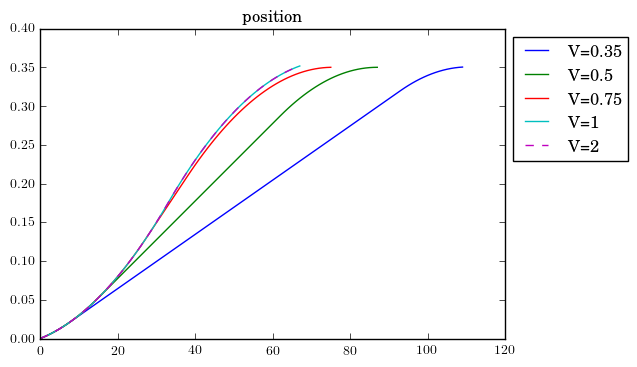

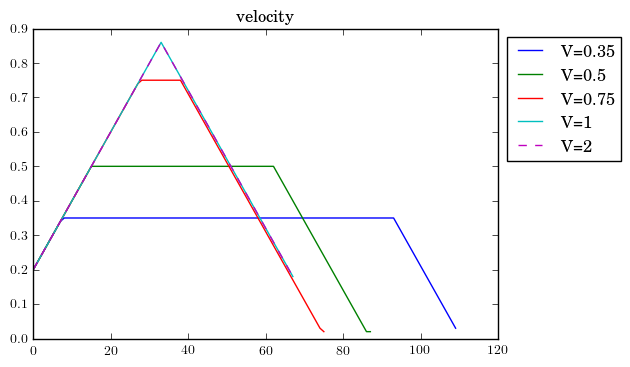

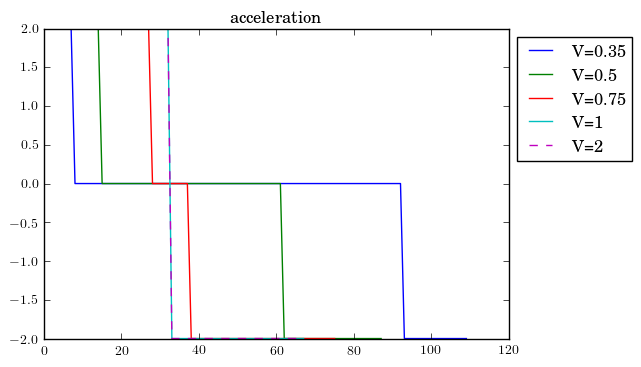

In [55]:
def profile(V0, Vf, Vmax, d, A, buffer=3e-3):
    v = V0
    x = 0
    a = A
    vs = [v]
    xs = [x]
    a_s = [a]
    
    dt = 0.01
    while x < d:
        x = x + v*dt + a*dt*dt/2.0
        v = v + a*dt
        ramp_d = (v*v+ - Vf*Vf) / (2.0*A)
        if (d-x) < ramp_d + buffer:
            a = -A
        elif v < Vmax:
            a = A
        else:
            a = 0
        
        if v > Vmax:
            v = Vmax
        elif v < Vf:
            v = Vf
                
        xs.append(x)
        vs.append(v)
        a_s.append(a)
        
    return xs, vs, a_s

def graph(title, idx):
    plt.figure()
    plt.title(title)
    Vs = [0.35, 0.5, 0.75, 1, 2]
    Vf = 0.02
    V0 = 0.2
    d = 0.35
    a = 2
    for V in Vs:    
        results  = profile(V0, Vf, V, d, a)
        vs = results[1]
        if V == 2: # make V=2 dashed so we can see it over V=1
            plt.plot(results[idx], label='V={}'.format(V), linestyle='dashed')
        else:
            plt.plot(results[idx], label='V={}'.format(V))
        plt.legend(bbox_to_anchor=(1, 1), loc=2)

graph("position", 0)
graph("velocity", 1)
graph("acceleration", 2)
plt.show()

## General Form Trajectory Planning

Let's start out with a generating trajectories that are not time optimal, but rely on specifying the final time $v_f$. For smartmouse, our state space is $[x, y, \theta]$, and a turn can be defined as starting at a point $[x_0, y_0, \theta_0]$ and going to $[x_f, y_f, \theta_0]$. Of course, we also want to specify the velocities at these point, $[\dot{x}_0, \dot{y}_0,\dot{\theta}_0]$ and $[\dot{x}_f, \dot{y}_f,\dot{\theta}_f]$. We have four constraints, so if we want to fit a smooth polynomial to those points we need a 4th order polynomial.

$$q(t) = a_0 + a_1t + a_2t^2 + a_3t^3$$
$$\dot{q}(t) = a_1 + 2a_2t + 3a_3t^2$$

If we sub in our constraints, we get the following system of equations.

\begin{align}
q(0) &= a_0 \\
\dot{q}(0) &= a_1 \\
q(t_f) &= a_0 + a_1t_f + a_2{t_f}^2 + a_3{t_f}^3\\
\dot{q}(t_f) &= a_1 + 2a_2t_f + 3a_3{t_f}^2\\
\end{align}

In matrix form that looks like:
\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
1 & t_f & t_f^2 & t_f^3 \\
0 & 1 & 2t_f & 3t_f^2 \\
\end{bmatrix}
\begin{bmatrix}
a_0 \\
a_1 \\
a_2 \\
a_3 \\
\end{bmatrix} =
\begin{bmatrix}
q(0) \\
\dot{q}(0) \\
q(t_f) \\
\dot{q}(t_f) \\
\end{bmatrix}
\end{equation}

It can be shown that the matrix on the left is invertable, so long as $t_f-t_0 > 0$. So we can invert and solve this equation and get all the $a$ coefficients. We can then use this polynomial to generate the $q(t)$ and $\dot{q}(t)$ -- our trajectory.

In [56]:
# Example: you are a point in space (one dimension) go from rest at the origin to at rest at (0.18, 0, 0) in 1 second
q_0 = np.array([0])
q_dot_0 = np.array([0])
q_f = np.array([0.18])
q_dot_f = np.array([0])
t_f = 1

b = np.array([q_0, q_dot_0, q_f, q_dot_f])
a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
print(a, b)
coeff = np.linalg.solve(a, b)
print(coeff)


[[1 0 0 0]
 [0 1 0 0]
 [1 1 1 1]
 [0 1 2 3]] [[ 0.  ]
 [ 0.  ]
 [ 0.18]
 [ 0.  ]]
[[ 0.  ]
 [ 0.  ]
 [ 0.54]
 [-0.36]]


Here you can see that the resulting coeffictions are $a_0=0$, $a_1=0$, $a_2=0.54$, $a_0=-0.36$. Intuitively, this says that we're going to have positive acceleration, but our acceleration is going to slow down over time. Let's graph it!

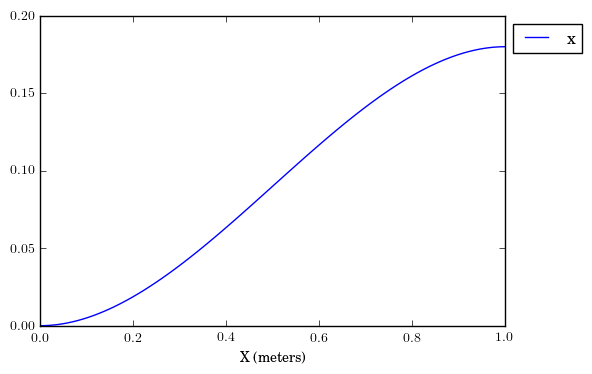

In [57]:
dt = 0.01
ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
qs = ts@coeff
plt.plot(ts[:,1], qs, label="x")
plt.xlabel("time (seconds)")
plt.xlabel("X (meters)")
plt.legend(bbox_to_anchor=(1,1), loc=2)
plt.show()

**ooooooooooh so pretty**

Let's try another example, now with our full state space of $[x, y, \theta]$.

[[ 0.09  0.09  0.  ]
 [ 0.    0.    0.  ]
 [ 0.54  0.27 -4.71]
 [-0.36 -0.18  3.14]]


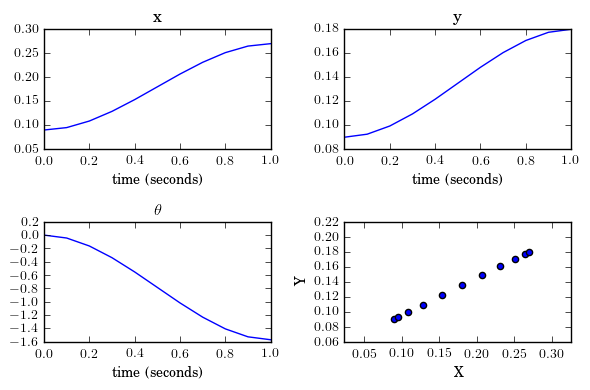

In [58]:
# In this example, we go from (0.18, 0.09, 0) to (0.27,0.18, -1.5707). Our starting and ending velocities are zero
q_0 = np.array([0.09,0.09,0])
q_dot_0 = np.array([0,0,0])
q_f = np.array([0.27,0.18,-1.5707])
q_dot_f = np.array([0,0,0])
t_f = 1

b = np.array([q_0, q_dot_0, q_f, q_dot_f])
a = np.array([[1,0,0,0],[0,1,0,0],[1, t_f, pow(t_f,2),pow(t_f,3)],[0,1,2*t_f,3*pow(t_f,2)]])
coeff = np.linalg.solve(a, b)
print(coeff)

dt = 0.1
ts = np.array([[1, t, pow(t,2), pow(t,3)] for t in np.arange(0, t_f+dt,  dt)])
qs = ts@coeff

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.gca().set_adjustable("box")
plt.subplot(221)
plt.plot(ts[:,1], qs[:,0])
plt.xlabel("time (seconds)")
plt.title("x")
plt.subplot(222)
plt.plot(ts[:,1], qs[:,1])
plt.xlabel("time (seconds)")
plt.title("y")
plt.subplot(223)
plt.plot(ts[:,1], qs[:,2])
plt.xlabel("time (seconds)")
plt.title(r"$\theta$")
plt.subplot(224)
plt.scatter(qs[:,0], qs[:,1])
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

Well, they are smooth, but these are not possible to execute! The robot cannot simply translate sideways.

## Trajectory Planning With a Simple Dynamics Model

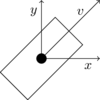

In [59]:
%%tikz -s 100,100

\draw [rotate around={-45:(0,0)}] (-.5,-1) rectangle (0.5,1);
\filldraw (0,0) circle (0.125);

\draw [->] (0,0) -- (0,1.5);
\draw [->] (0,0) -- (1.5,0);
\draw [->] (0,0) -- (1.5,1.5);
\draw (1.2, -0.2) node {$x$};
\draw (-0.2, 1.2) node {$y$};
\draw (1, 1.2) node {$v$};


We need to change our constraints to the system of equations. Specifically, we need our dynamics model. For now, let's assume a simplified car model.

$$ \dot{x} = v\cos(\theta) $$
$$ \dot{y} = v\sin(\theta) $$

This basically claims that for any instant in time the robot is moving a constant velocity along $\theta$. This isn't very accurate, but let's just start with that since the real dynamics of our robot are more complex.

First we will bring in the constraints from before. We must satisfy specific initial and final positions in $[x, y, \theta]$. I've used new letters for cofficients to avoid confusion.

\begin{align}
x(0) &= c_0 + c_1(0) + c_2(0)^2 + c_3(0)^3\\
y(0) &= d_0 + d_1(0) + d_2(0)^2 + d_3(0)^3\\
x(t_f) &= c_0 + c_1(t_f) + c_2(t_f)^2 + c_3(t_f)^3\\
y(t_f) &= d_0 + d_1(t_f) + d_2(t_f)^2 + d_3(t_f)^3
\end{align}

Notice here we have 8 unknowns, $c_0 \dots c_3$ and $d_0 \dots d_3$. So we're gonna need more equations for there to be a unique solution. Also notice we haven't defined any constraints related to our dynamics model. That would be a good place to get our other equations!

**TODO:** the rank of the system with 8 equations was 6, so there were multiple solutions. I'm working on adding constraints on initial final velocities to hopefully fix that.

First, we want to be able to specify initial velocity $v_0$ and final velocity $v_{t_f}$.

\begin{align}
v_0 &= c_1\cos(\theta_0) + d_1\sin(\theta_0) \\
v_{t_f} &= (0)c_0 + \cos(\theta_{t_f})c_1 + 2\cos(\theta_{t_f})t_fc_2 + 3\cos(\theta_{t_f}){t_f}^2c_3 + (0)d_0 + \sin(\theta_{t_f})d_1 + 2\sin(\theta_{t_f})t_fd_2 + 3\sin(\theta_{t_f}){t_f}^2d_3
\end{align}

Let's also make sure x and y components obey trigonometry.

\begin{align}
  v\cos(\theta)\sin(\theta) + v\cos(\theta)\sin(\theta) &= v\sin(2\theta) \\
  \dot{x}\sin(\theta) + \dot{y}\sin(\theta) &= v\sin(2\theta)
\end{align}

We can get two equations out of this by specifying initial and final velocities

\begin{align}
v_0\sin(2\theta_0) &= \dot{x}_0\sin(\theta_0) + \dot{y}_0\cos(\theta_0) \\
v_{t_f}\sin(2\theta_{t_f}) &= \dot{x}_{t_f}\sin(\theta_{t_f}) + \dot{y}_{t_f}\cos(\theta_{t_f})
\end{align}

We should write out the full form though, to make things terms of our coefficients.

\begin{align}
v(0)\sin(2\theta_0) &= \Big[c_1 + 2c_2(0) + 3c_3(0)^2\Big]\sin(\theta_0) + \Big[d_1 + 2d_2(0) + 3d_3(0)^2\Big]\cos(\theta_0) \\
v(0)\sin(2\theta_0) &= (0)c_0 + \sin(\theta_0)c_1 + (0)c_2 + (0)c_3 + (0)d_0 + \cos(\theta_0)d_1 + (0)d_2 + (0)d_3 
\end{align}

\begin{align}
v(t_f)\sin(2\theta_{t_f}) &= \Big[c_1 + 2c_2(t_f) + 3c_3(t_f)^2\Big]\sin(\theta_{t_f}) + \Big[d_1 + 2d_2(t_f) + 3d_3(t_f)^2\Big]\cos(\theta_{t_f}) \\
v(t_f)\sin(2\theta_{t_f}) &= (0)c_0 + \sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 + (0)d_0 + \cos(\theta_{t_f})d_1 + 2\cos(\theta_{t_f})t_fd_2 + 3\cos(\theta_{t_f}){t_f}^2d_3 \\
\end{align}

The last two equations will just be some equation relating $\dot{x}$ to $\dot{y}$. Let's just make one up...

\begin{align}
v\cos(\theta)\sin(\theta) - v\cos(\theta)\sin(\theta) &= 0 \\
v\cos(\theta)\sin(\theta) - v\sin(\theta)\cos(\theta) &= 0 \\
\dot{x}\sin(\theta) - \dot{y}\cos(\theta) &= 0
\end{align}

and again written out fully in terms of our coefficients

\begin{align}
\Big[c_1 + 2c_2(0) + 3c_3(0)^2\Big]\sin(\theta_0) - \Big[d_1 + 2d_2(0) + 3d_3(0)^2\Big]\cos(\theta_0) &= 0 \\
(0)c_0 + \sin(\theta_0)c_1 + (0)c_2 + (0)c_3 - (0)d_0 - \cos(\theta_0)d_1 - (0)d_2 - (0)d_3 &= 0
\end{align}

\begin{align}
\Big[c_1 + 2c_2(t_f) + 3c_3(t_f)^2\Big]\sin(\theta_{t_f}) - \Big[d_1 + 2d_2(t_f) + 3d_3(t_f)^2\Big]\cos(\theta_{t_f}) &= 0 \\
(0)c_0 + \sin(\theta_{t_f})c_1 + 2\sin(\theta_{t_f})t_fc_2 + 3\sin(\theta_{t_f}){t_f}^2c_3 - (0)d_0 - \cos(\theta_{t_f})d_1 - 2\cos(\theta_{t_f})t_fd_2 - 3\cos(\theta_{t_f}){t_f}^2d_3 &= 0
\end{align}

Ok, that should work. Now let's write it out in matrix form.

\begin{equation}
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & 0 & 0 & 0 \\
0 & \sin(\theta_0) & 0 & 0 & 0 & \cos(\theta_0) & 0 & 0 \\
0 & \sin(\theta_0) & 0 & 0 & 0 & -\cos(\theta_0) & 0 & 0 \\
1 & t & {t_f}^2 & {t_f}^3 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 1 & t_f & {t_f}^2 & {t_f}^3 \\
0 & \sin(\theta_{t_f}) & 2\sin(\theta_{t_f})t_f & 3\sin(\theta_{t_f}){t_f}^2 & 0 & \cos(\theta_{t_f}) & 2\cos(\theta_{t_f}){t_f} & 3\cos(\theta_{t_f}){t_f}^2 \\
0 & \sin(\theta_{t_f}) & 2\sin(\theta_{t_f})t_f & 3\sin(\theta_{t_f}){t_f}^2 & 0 & -\cos(\theta_{t_f}) & -2\cos(\theta_{t_f}){t_f} & -3\cos(\theta_{t_f}){t_f}^2 \\
\end{bmatrix}
\begin{bmatrix}
c_0 \\
c_1 \\
c_2 \\
c_3 \\
d_0 \\
d_1 \\
d_2 \\
d_3 \\
\end{bmatrix} =
\begin{bmatrix}
x_0 \\
y_0 \\
0 \\
v_0\sin(2\theta_0) \\
x_{t_f} \\
y_{t_f} \\
0 \\
v_{t_f}\sin(2\theta_{t_f}) \\
\end{bmatrix}
\end{equation}

[[    1.       0.       0.       0.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       1.       0.       0.       0.  ]
 [    0.       0.71     0.       0.       0.      -0.71     0.       0.  ]
 [    0.       0.71     0.       0.       0.       0.71     0.       0.  ]
 [    1.      10.     100.    1000.       0.       0.       0.       0.  ]
 [    0.       0.       0.       0.       1.      10.     100.    1000.  ]
 [    0.       0.71    14.14   212.13     0.      -0.71   -14.14  -212.13]
 [    0.       0.71    14.14   212.13     0.       0.71    14.14   212.13]]
[ 0.   -0.    0.2  -0.01  9.   -0.    0.34 -0.03]


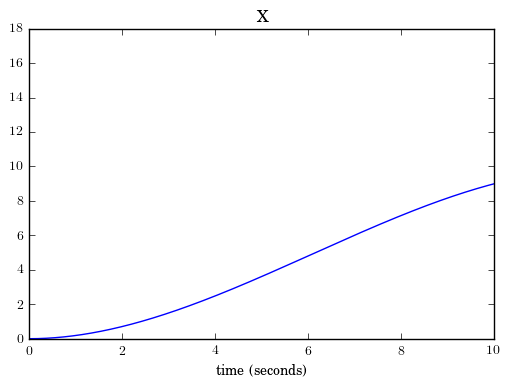

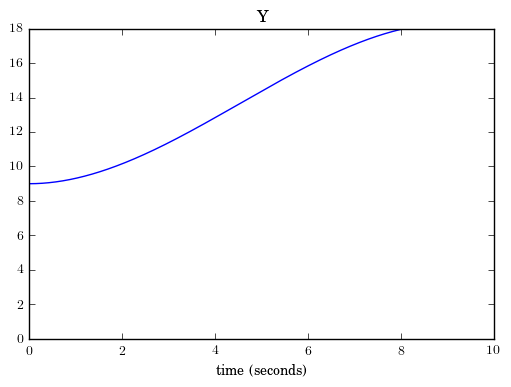

In [60]:
# Let's solve this in code like we did before
from math import sin, cos, pi

q_0 = [0, 9, pi/4]
q_t_f = [9, 18, pi/4]
t_f = 10
v_0 = 0
v_f = 1

A = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0],
              [0, sin(q_0[2]), 0, 0, 0, -cos(q_0[2]), 0, 0],
              [0, sin(q_0[2]), 0, 0, 0, cos(q_0[2]), 0, 0],
              [1, t_f, pow(t_f,2), pow(t_f,3), 0, 0, 0, 0],
              [0, 0, 0, 0, 1, t_f, pow(t_f,2), pow(t_f,3)],
              [0, sin(q_t_f[2]), 2*sin(q_t_f[2])*t_f, 3*sin(q_t_f[2])*pow(t_f,2), 0, -cos(q_t_f[2]), -2*cos(q_t_f[2])*t_f, -3*cos(q_t_f[2])*pow(t_f,2)],
              [0, sin(q_t_f[2]), 2*sin(q_t_f[2])*t_f, 3*sin(q_t_f[2])*pow(t_f,2), 0,  cos(q_t_f[2]),  2*cos(q_t_f[2])*t_f,  3*cos(q_t_f[2])*pow(t_f,2)],
             ])
B = np.array([q_0[0], q_0[1], v_0*sin(2*q_0[2]), 0, q_t_f[0], q_t_f[1], v_f*sin(2*q_t_f[2]), 0])

rank = np.linalg.matrix_rank(A)
if rank < A.shape[1]:
    print("RANK DEFICIENT! {} < {}".format(rank, A.shape[1]))
    coeff = np.linalg.lstsq(A, B)[0]
else:
    coeff = np.linalg.solve(A, B)
    
print(A)
print(coeff)

dt = 0.01
T = np.arange(0, t_f+dt, dt)
xts = np.array([[1, t, pow(t,2), pow(t,3), 0, 0, 0, 0] for t in T])
yts = np.array([[0, 0, 0, 0, 1, t, pow(t,2), pow(t,3)] for t in T])
xs = xts@coeff
ys = yts@coeff

plt.figure()
plt.plot(T, xs)
plt.ylim(0,18)
plt.xlabel("time (seconds)")
plt.title("X")
plt.show()

plt.figure()
plt.plot(T, ys)
plt.ylim(0,18)
plt.xlabel("time (seconds)")
plt.title("Y")

plt.show()

## Finally, let's graph the trajectory in X/Y

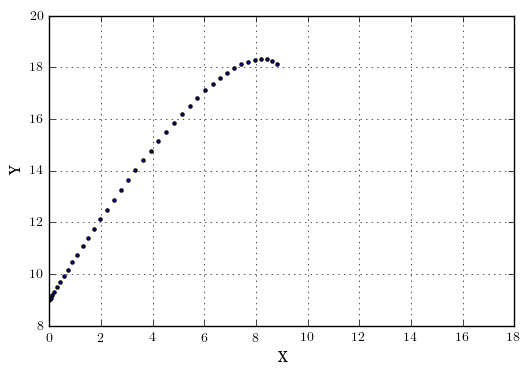

In [44]:
plt.scatter(xs[1::25], ys[1::25], marker='.')
plt.axis('equal')
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(0, 18)
plt.grid(True)
plt.show()

## Questions for FU

 - I understand we need another equation that constrains the relation between $\dot{x}$ and $\dot{y}$, but why is it $\dot{x}\sin(\theta) - \dot{y}\cos(\theta) = 0$? Can we use other equations?
 - How is it possible to satisfy both $\dot{x}\sin(\theta) - \dot{y}\cos(\theta) = 0$ and $\dot{x}\sin(\theta) + \dot{y}\cos(\theta) = 0$ ???? **answer** Becuase the second equation is only true at t=0 and t=T
 - It seems there is no constraint on $\theta$ being a smooth 3rd order polynomial? Whyyyyyyyyy?

** Graph of theta over time from the matlab code **
![Theta](dank_theta.jpg)

 - Why can't I change it to $\dot{x}\sin(\theta_{t_f}) + \dot{y}\cos(\theta_{t_f}) = 1$